# Introducción práctica a Imágenes Satelitales con NDVI (Sentinel-2)

**Objetivo:** aprender a cargar bandas multiespectrales (B4 y B8), calcular el NDVI, visualizar resultados, obtener estadísticas básicas, y guardar el resultado a GeoTIFF.

## 1) Importaciones y rutas de datos
Modifique las rutas a las bandas **B4** (rojo) y **B8** (NIR). Para Sentinel-2, lo típico es trabajar con archivos `.tif` a 10 m.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import os
from rasterio.enums import Resampling

# Rutas de ejemplo: ajuste a su caso
PATH_B4 = 'data/2025-11-08-00_00_2025-11-08-23_59_Sentinel-2_L1C_B04_(Raw).tiff'   # Banda roja
PATH_B8 = 'data/2025-11-08-00_00_2025-11-08-23_59_Sentinel-2_L1C_B08_(Raw).tiff'   # Banda NIR
PATH_TRUE_COLOR = 'data/2025-11-08-00_00_2025-11-08-23_59_Sentinel-2_L1C_True_color.tiff'

# Opcional (una de las dos): QA60 (máscara de nubes por bits) o SCL (clasificación de escena)
PATH_QA60 = None  # 'data/S2A_QA60.tif'  # Bits 10 (nubes) y 11 (cirros)
PATH_SCL  = None  # 'data/S2A_SCL_20m.tif'  # Clasificación de escena (20 m)


## 2) Funciones auxiliares
- Alineación espacial y de resolución de rasters
- Cálculo de NDVI
- Máscara de nubes opcional (QA60 o SCL)


In [2]:
def read_raster(path):
    ds = rasterio.open(path)
    arr = ds.read(1)
    return ds, arr

def read_raster_rgb(path):
    """Lee un raster con múltiples bandas (RGB) y devuelve el array en formato (H, W, C)."""
    ds = rasterio.open(path)
    # Lee todas las bandas y reorganiza a (H, W, C) para matplotlib
    arr = ds.read()  # Shape: (C, H, W)
    arr = np.transpose(arr, (1, 2, 0)).astype(np.float32)
    # Normaliza a 0-1 para visualización
    arr_min, arr_max = arr.min(), arr.max()
    if arr_max > arr_min:
        arr = (arr - arr_min) / (arr_max - arr_min)
    return ds, arr

def resample_to_match(src_ds, src_arr, ref_ds):
    """Resamplea src_arr (src_ds) para que coincida con la forma/proyección de ref_ds."""
    data = np.empty((1, ref_ds.height, ref_ds.width), dtype=src_arr.dtype)
    rasterio.warp.reproject(
        source=src_arr,
        destination=data[0],
        src_transform=src_ds.transform,
        src_crs=src_ds.crs,
        dst_transform=ref_ds.transform,
        dst_crs=ref_ds.crs,
        resampling=Resampling.bilinear,
    )
    return data[0]

def compute_ndvi(nir, red):
    nir = nir.astype('float32')
    red = red.astype('float32')
    num = (nir - red)
    den = (nir + red)
    with np.errstate(divide='ignore', invalid='ignore'):
        ndvi = np.where(den == 0, np.nan, num / den)
    return ndvi

def mask_clouds_qa60(qa60):
    """Devuelve una máscara booleana True para píxeles despejados (no nubes/cirros).
    Bits: 10 = clouds, 11 = cirrus."""
    # Extrae bits 10 y 11
    cloud_bit = (qa60 & (1 << 10)) != 0
    cirrus_bit = (qa60 & (1 << 11)) != 0
    clear = ~(cloud_bit | cirrus_bit)
    return clear

def mask_clouds_scl(scl):
    """Máscara booleana True = píxeles válidos (sin nubes/niebla/sombra). Basado en clases SCL Sentinel-2.
    Referencia (resumen): 0 No data; 1 Saturated/Defective; 2 Dark Area; 3 Cloud Shadows; 4 Vegetation; 5 Bare; 6 Water; 7 Unclassified;
    8 Cloud Medium; 9 Cloud High; 10 Cirrus; 11 Snow/Ice.
    Ajuste según su criterio de calidad.
    """
    bad_classes = {0,1,3,8,9,10,11}
    mask_good = ~np.isin(scl, list(bad_classes))
    return mask_good


## 3) Carga de bandas y alineación (si es necesario)
Esta celda abre las bandas B4 y B8. Si sus resoluciones/transformaciones difieren, B4 se re-muestrea a la malla de B8 (o viceversa).


In [3]:
ds_b4, b4 = read_raster(PATH_B4)
ds_b8, b8 = read_raster(PATH_B8)

# Si las dimensiones difieren, re-muestrear B4 a la malla de B8
if (ds_b4.width != ds_b8.width) or (ds_b4.height != ds_b8.height) or (ds_b4.transform != ds_b8.transform):
    b4 = resample_to_match(ds_b4, b4, ds_b8)

print("B4 shape:", b4.shape, "B8 shape:", b8.shape)


B4 shape: (684, 1030) B8 shape: (684, 1030)


## 5) Cargar máscara de nubes y generar máscara de validez
- Si se usa **QA60**: elimina nubes/cirros por bits.
- Si se usa **SCL**: conserva clases "buenas" (vegetación, suelo, agua) y filtra nubes/sombras.


In [4]:
valid_mask = None
if PATH_QA60:
    ds_q, qa = read_raster(PATH_QA60)
    if (ds_q.width != ds_b8.width) or (ds_q.height != ds_b8.height) or (ds_q.transform != ds_b8.transform):
        qa = resample_to_match(ds_q, qa, ds_b8)
    valid_mask = mask_clouds_qa60(qa)
elif PATH_SCL:
    ds_s, scl = read_raster(PATH_SCL)
    # SCL suele estar a 20 m; re-muestre a 10 m con nearest
    scl_10m = np.empty((ds_b8.height, ds_b8.width), dtype=scl.dtype)
    rasterio.warp.reproject(
        source=scl,
        destination=scl_10m,
        src_transform=ds_s.transform,
        src_crs=ds_s.crs,
        dst_transform=ds_b8.transform,
        dst_crs=ds_b8.crs,
        resampling=Resampling.nearest,
    )
    valid_mask = mask_clouds_scl(scl_10m)

if valid_mask is not None:
    print("Máscara válida (True=usable):", valid_mask.shape, np.mean(valid_mask), "proporción válida")
else:
    print("Sin máscara de nubes: se usará todo el ráster.")


Sin máscara de nubes: se usará todo el ráster.


## 7) Cálculo de NDVI
NDVI = (NIR - Red) / (NIR + Red). Se manejan divisiones por cero como `NaN`.


In [5]:
ndvi = compute_ndvi(b8, b4)
if valid_mask is not None:
    ndvi = np.where(valid_mask, ndvi, np.nan)
ndvi_min, ndvi_max = np.nanmin(ndvi), np.nanmax(ndvi)
print(f"NDVI rango: min={ndvi_min:.3f}, max={ndvi_max:.3f}")


NDVI rango: min=-0.057, max=0.800


## 7) Visualización y estadísticas básicas
- Mapa NDVI (1 figura)
- Histograma de NDVI (1 figura)
- Valores estadísticos (media, mediana, percentiles)


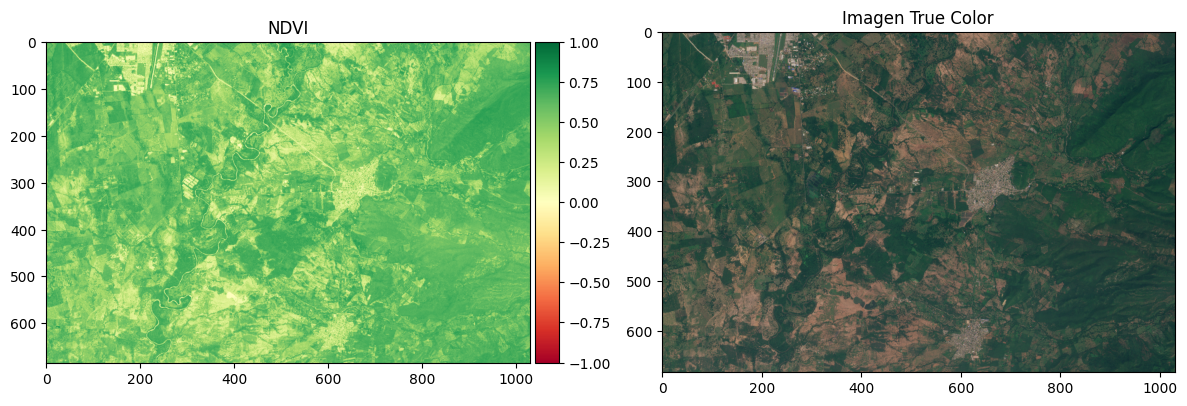

In [6]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

_, img = read_raster_rgb(PATH_TRUE_COLOR)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

im1 = ax1.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
ax1.set_title('NDVI')
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax1)

ax2.imshow(img)
ax2.set_title('Imagen True Color')

plt.tight_layout()
plt.show()


Ubicación del máximo NDVI (fila, columna): (np.int64(51), np.int64(511))


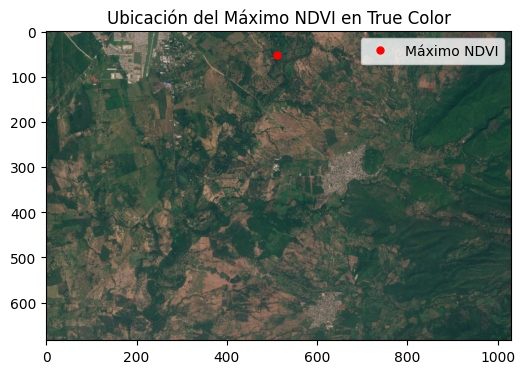

In [12]:
# Ubicación del máximo ndvi en filas y columnas
max_ndvi_idx = np.unravel_index(np.nanargmax(ndvi), ndvi.shape)
print("Ubicación del máximo NDVI (fila, columna):", max_ndvi_idx)

# Visualización del píxel con máximo NDVI en la imagen true color
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(img)
ax.plot(max_ndvi_idx[1], max_ndvi_idx[0], 'ro', markersize=5, label='Máximo NDVI')
ax.set_title('Ubicación del Máximo NDVI en True Color') 
ax.legend()

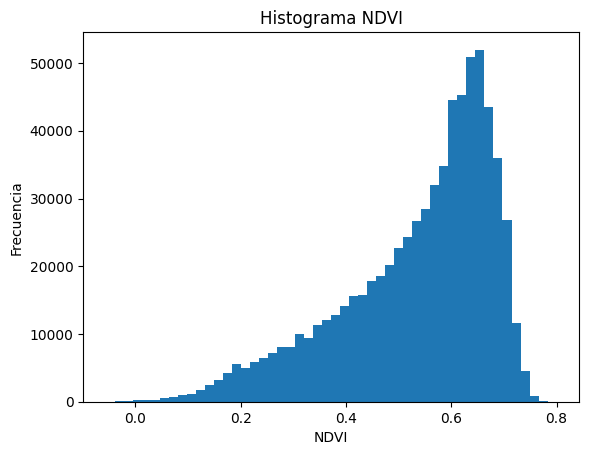

{'mean': 0.5357559323310852, 'median': 0.5764706134796143, 'p10': 0.3186813294887543, 'p90': 0.6842105388641357}


In [13]:
plt.figure()
vals = ndvi[np.isfinite(ndvi)].ravel()
plt.hist(vals, bins=50)
plt.title('Histograma NDVI')
plt.xlabel('NDVI')
plt.ylabel('Frecuencia')
plt.show()

mean = float(np.nanmean(ndvi))
median = float(np.nanmedian(ndvi))
p10, p90 = float(np.nanpercentile(ndvi, 10)), float(np.nanpercentile(ndvi, 90))
print({"mean": mean, "median": median, "p10": p10, "p90": p90})


## 8) Guardar NDVI como GeoTIFF
El archivo se guardará con la misma proyección y transformada espacial que la banda de referencia.


In [ ]:
out_path = 'outputs/ndvi.tif'
os.makedirs(os.path.dirname(out_path), exist_ok=True)
profile = ds_b8.profile.copy()
profile.update(dtype=rasterio.float32, count=1, nodata=np.nan)
with rasterio.open(out_path, 'w', **profile) as dst:
    dst.write(ndvi.astype('float32'), 1)
print('Guardado:', out_path)


## Tarea: Comparación de dos fechas y mapa de cambio
Proporcione dos pares de bandas B4/B8 (t1 y t2). El resultado será un **mapa de diferencia de NDVI** (t2 - t1).


In [ ]:
# Rutas de ejemplo para una segunda fecha (ajuste o deje en None)
PATH_B4_T2 = None  # 'data/S2B_B04_10m_T2.tif'
PATH_B8_T2 = None  # 'data/S2B_B08_10m_T2.tif'

if PATH_B4_T2 and PATH_B8_T2:
    ds_b4_t2, b4_t2 = read_raster(PATH_B4_T2)
    ds_b8_t2, b8_t2 = read_raster(PATH_B8_T2)
    if (ds_b4_t2.width != ds_b8.width) or (ds_b4_t2.height != ds_b8.height) or (ds_b4_t2.transform != ds_b8.transform):
        b4_t2 = resample_to_match(ds_b4_t2, b4_t2, ds_b8)
    if (ds_b8_t2.width != ds_b8.width) or (ds_b8_t2.height != ds_b8.height) or (ds_b8_t2.transform != ds_b8.transform):
        b8_t2 = resample_to_match(ds_b8_t2, b8_t2, ds_b8)
    ndvi_t2 = compute_ndvi(b8_t2, b4_t2)
    if valid_mask is not None:
        ndvi_t2 = np.where(valid_mask, ndvi_t2, np.nan)
    d_ndvi = ndvi_t2 - ndvi
    plt.figure()
    plt.imshow(d_ndvi)
    plt.title('Cambio NDVI (t2 - t1)')
    plt.colorbar()
    plt.show()
else:
    print('Proporcione PATH_B4_T2 y PATH_B8_T2 para calcular el cambio de NDVI entre fechas.')


## (Tarea opcional) Estadísticas zonales por polígonos
Calcule estadísticas de NDVI por polígonos (veredas, fincas, municipios, etc.). Requiere `geopandas` y `rasterstats`.


In [ ]:
USE_ZONAL = False  # Cambie a True si quiere ejecutar
VECTOR_PATH = 'data/zonas.gpkg'  # o .shp/.geojson

if USE_ZONAL:
    import geopandas as gpd
    from rasterstats import zonal_stats
    gdf = gpd.read_file(VECTOR_PATH)
    stats = zonal_stats(
        gdf, out_path, stats=['count','mean','median','percentile_10','percentile_90'],
        nodata=np.nan
    )
    gdf_out = gdf.copy()
    gdf_out = gdf_out.join(np.array(stats).view(np.recarray))
    gdf_out.to_file('outputs/ndvi_stats.gpkg', driver='GPKG')
    print('Guardado: outputs/ndvi_stats.gpkg')
else:
    print('Active USE_ZONAL=True y ajuste VECTOR_PATH para calcular estadísticas zonales.')
